In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import category_encoders as ce

In [19]:
df = pd.read_csv('../data/raw/Waste_Management_and_Recycling_India.csv')

In [20]:
df.columns = df.columns.str.strip()

In [21]:
if 'Landfill Location (Lat, Long)' in df.columns:
    # Assuming it's a string like "(12.34, 56.78)"
    df[['Landfill Latitude', 'Landfill Longitude']] = df['Landfill Location (Lat, Long)']\
        .str.strip('()').str.split(',', expand=True).astype(float)
    df.drop(columns=['Landfill Location (Lat, Long)'], inplace=True)

In [22]:
# Handle missing values (simple example: fill numeric with median, categorical with mode)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [23]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [24]:
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [25]:
# --- Feature Engineering ---
# 1. Waste per Population Density (avoid divide by zero)
df['Waste_per_Density'] = df['Waste Generated (Tons/Day)'] / (df['Population Density (People/km²)'] + 1)


In [26]:
# 2. Landfill Utilization Ratio
df['Landfill_Utilization'] = df['Waste Generated (Tons/Day)'] / (df['Landfill Capacity (Tons)'] + 1)

In [27]:
# 3. Interaction: Efficiency × Awareness Campaigns
df['Efficiency_Awareness'] = df['Municipal Efficiency Score (1-10)'] * df['Awareness Campaigns Count']

In [28]:
# 4. Cost Efficiency
df['Cost_per_Ton_Generated'] = df['Cost of Waste Management (₹/Ton)'] / (df['Waste Generated (Tons/Day)'] + 1)

In [29]:
# 5. Recycling to Landfill Ratio
df['Recycling_Landfill_Ratio'] = df['Recycling Rate (%)'] / (df['Landfill Capacity (Tons)'] + 1)

In [30]:
# 6. Geospatial features - distance from some reference point (e.g., centroid of India)
# Approximate India centroid coordinates: lat=22.5937, long=78.9629
df['Landfill_Distance_to_Center'] = np.sqrt(
    (df['Landfill Latitude'] - 22.5937)**2 + (df['Landfill Longitude'] - 78.9629)**2
)

In [31]:
# 7. Year as categorical (for seasonality/trend capture)
df['Year'] = df['Year'].astype(str)

In [32]:
# --- Encoding Categorical Variables ---
# List categorical columns to encode for model input
cat_features = ['City/District', 'Waste Type', 'Disposal Method', 'Landfill Name', 'Year']


In [33]:
# Using Target Encoding for some categorical variables (except target itself)
target_encoder = ce.TargetEncoder(cols=['Waste Type', 'Disposal Method'])

In [34]:
df = target_encoder.fit_transform(df, df['Recycling Rate (%)'])

In [36]:
# One-Hot Encoding for City and Landfill Name (high cardinality, but example uses OHE)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
city_encoded = ohe.fit_transform(df[['City/District']])
landfill_encoded = ohe.fit_transform(df[['Landfill Name']])

In [37]:
# Create DataFrames for encoded features
city_ohe_df = pd.DataFrame(city_encoded, columns=[f"city_{c}" for c in ohe.categories_[0]], index=df.index)
landfill_ohe_df = pd.DataFrame(landfill_encoded, columns=[f"landfill_{c}" for c in ohe.categories_[0]], index=df.index)

In [38]:
# Drop original city/landfill columns and concat encoded
df = df.drop(columns=['City/District', 'Landfill Name'])
df = pd.concat([df, city_ohe_df, landfill_ohe_df], axis=1)

In [39]:
# --- Prepare Features and Target ---

X = df.drop(columns=['Recycling Rate (%)'])
y = df['Recycling Rate (%)']

In [40]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:

# Scale numeric features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()

In [42]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [43]:
# --- Model Training ---

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [44]:

# Prediction
y_pred = model.predict(X_test)

In [45]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor Performance:")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Random Forest Regressor Performance:
RMSE: 2.684
R^2 Score: 0.974


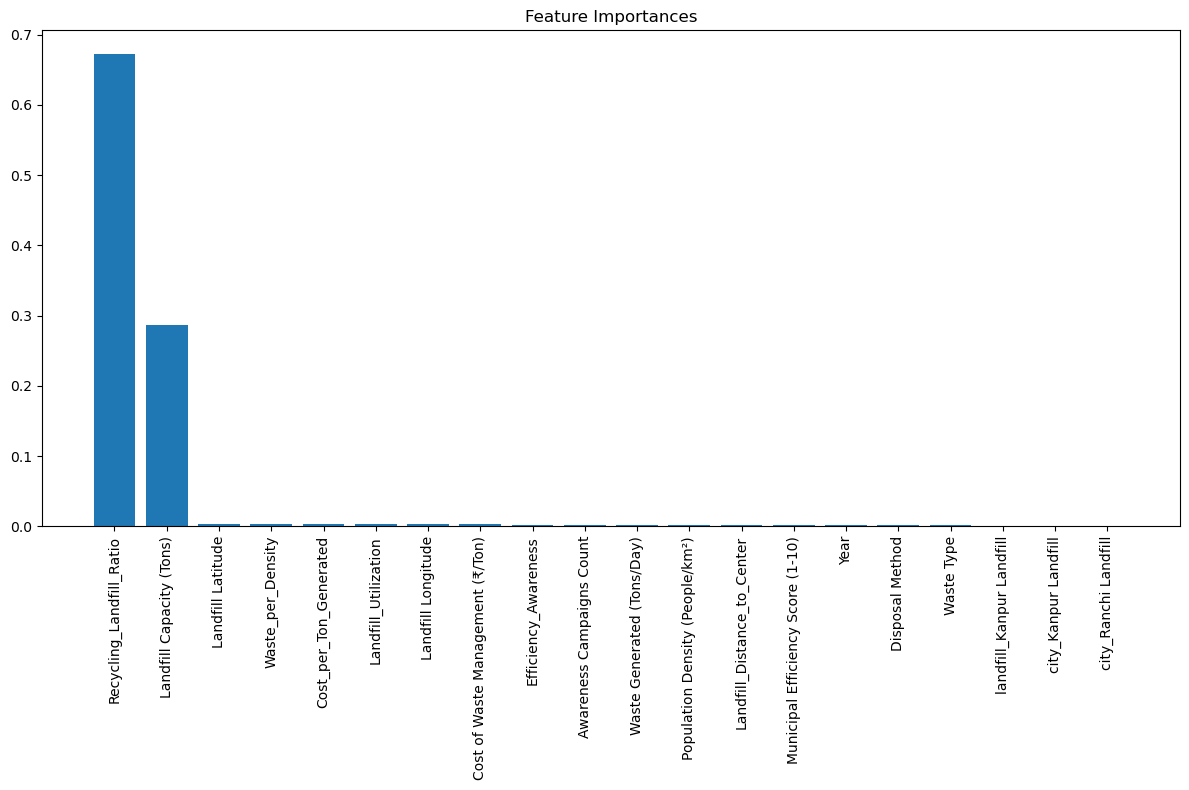

In [46]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), feat_names[indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

In [47]:
r2 = r2_score(y_test, y_pred)
accuracy_percent = r2 * 100
print(f"Model accuracy (R²) in percentage: {accuracy_percent:.2f}%")


Model accuracy (R²) in percentage: 97.35%


In [48]:
# After training the model
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")


Train R²: 0.996
Test R²: 0.974


In [49]:
import joblib

# Save model to file
joblib.dump(model, 'random_forest_waste_model.joblib')

# Later, to load the model back:
# loaded_model = joblib.load('random_forest_waste_model.joblib')


['random_forest_waste_model.joblib']

In [50]:
import joblib
from sklearn.metrics import r2_score

# Load the saved model
loaded_model = joblib.load('random_forest_waste_model.joblib')

# Predict on test set
y_test_pred = loaded_model.predict(X_test)

# Evaluate
test_r2 = r2_score(y_test, y_test_pred)
print(f"Loaded model test R²: {test_r2:.3f}")


Loaded model test R²: 0.974
